In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time
import numpy as np

from helpers import get_sequences, iterate_minibatches, get_minibatches

import matplotlib.pyplot as plt
%matplotlib inline

#### First create a simple train and test set

In [2]:
# create a sine wave
n_samples = int(1e3)
min_x = 0
max_x = 100
x = np.linspace(min_x, max_x, n_samples)
sinx = np.sin(x)
# add a Gaussian noise to it
noise_m = 1
noise_sd = 0.5
noise = np.random.normal(noise_m, noise_sd, n_samples)
smooth = sinx+noise_m
y = sinx + noise

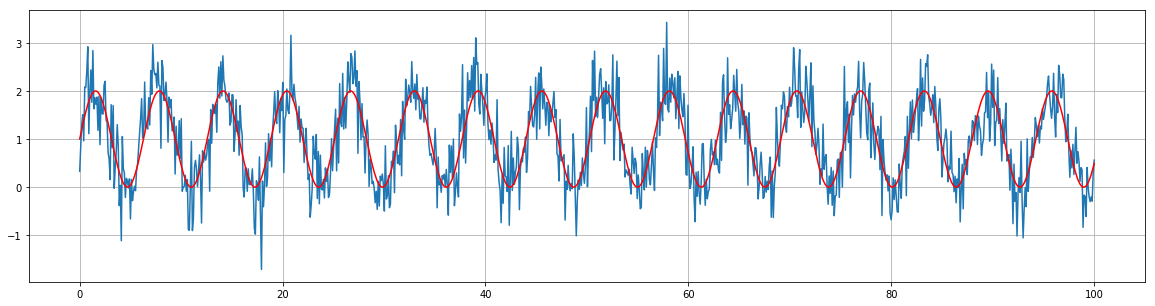

In [3]:
# plot
plt.figure(figsize=(20,5))
plt.plot(x, y, x, sinx+noise_m, 'r')
plt.grid(True)

In [4]:
# split it to train and test
slice_ind = int(n_samples*0.7)
# clear up namings for modeling
plot_train_x, train_x, plot_test_x, test_x, smooth_train_x, smooth_test_x = [x[:slice_ind], y[:slice_ind], 
                                                                             x[slice_ind:], y[slice_ind:], 
                                                                             smooth[:slice_ind], smooth[slice_ind:]]


# train_x, train_y, test_x, test_y, smooth_y_train, smooth_y_test = x[:slice_ind], y[:slice_ind], x[slice_ind:], y[slice_ind:], smooth[:slice_ind], smooth[slice_ind:]
# train_n, test_n = len(train_x), len(test_x)

# chunk it to each small window
seq_len = 5
train_x = get_sequences(train_x, seq_len, 1)

In [5]:
train_x.shape

(140, 5, 1)

In [6]:
test_x.shape

(300,)

#### So we observe the drift from lstm if it were to generate actual predictions
we employ a different training scheme 

In [7]:
def sampling_rnn(cell, initial_state, input_, seq_lengths):    
    # raw_rnn expects time major inputs as TensorArrays
    max_time = seq_len  # this is the max time step per batch
    inputs_ta = tf.TensorArray(dtype=tf.float32, size=max_time, clear_after_read=False)
    inputs_ta = inputs_ta.unstack(_transpose_batch_time(input_))  # model_input is the input placeholder
    input_dim = input_.get_shape()[-1].value  # the dimensionality of the input to each time step
    output_dim = 1  # the dimensionality of the model's output at each time step

    def loop_fn(time, cell_output, cell_state, loop_state):
        """
        Loop function that allows to control input to the rnn cell and manipulate cell outputs.
        :param time: current time step
        :param cell_output: output from previous time step or None if time == 0
        :param cell_state: cell state from previous time step
        :param loop_state: custom loop state to share information between different iterations of this loop fn
        :return: tuple consisting of
          elements_finished: tensor of size [bach_size] which is True for sequences that have reached their end,
            needed because of variable sequence size
          next_input: input to next time step
          next_cell_state: cell state forwarded to next time step
          emit_output: The first return argument of raw_rnn. This is not necessarily the output of the RNN cell,
            but could e.g. be the output of a dense layer attached to the rnn layer.
          next_loop_state: loop state forwarded to the next time step
        """
        if cell_output is None:
            # time == 0, used for initialization before first call to cell
            next_cell_state = initial_state
            # the emit_output in this case tells TF how future emits look
            emit_output = tf.zeros([output_dim])
        else:
            # t > 0, called right after call to cell, i.e. cell_output is the output from time t-1.
            # here you can do whatever ou want with cell_output before assigning it to emit_output.
            # In this case, we don't do anything
            next_cell_state = cell_state
#             emit_output = cell_output 
            emit_output = tf.contrib.layers.fully_connected(inputs=cell_output, num_outputs=output_dim)
        
        # check which elements are finished
        elements_finished = (time >= seq_lengths)
        finished = tf.reduce_all(elements_finished)

        # assemble cell input for upcoming time step
        current_output = emit_output if cell_output is not None else None
        input_original = inputs_ta.read(time)  # tensor of shape (None, input_dim)
        if current_output is None:
            # this is the initial step, i.e. there is no output from a previous time step, what we feed here
            # can highly depend on the data. In this case we just assign the actual input in the first time step.
            next_in = input_original
        else:
            # time > 0, so just use previous output as next input
            # here you could do fancier things, whatever you want to do before passing the data into the rnn cell
            # if here you were to pass input_original than you would get the normal behaviour of dynamic_rnn
#             next_in = input_original
            next_in = current_output

        next_input = tf.cond(finished,
                             lambda: tf.zeros([batch_size, input_dim], dtype=tf.float32),  # copy through zeros
                             lambda: next_in)  # if not finished, feed the previous output as next input
        # set shape manually, otherwise it is not defined for the last dimensions
        next_input.set_shape([None, input_dim])

        # loop state not used in this example
        next_loop_state = None
        return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)
    
    outputs_ta, last_state, _ = tf.nn.raw_rnn(cell, loop_fn)
    outputs = _transpose_batch_time(outputs_ta.stack())
    final_state = last_state
    print('before return in sampling_rnn=========================\n')
    return outputs, final_state

In [8]:
%%time
tf.reset_default_graph()

batch_size = 32
# n_batches = train_x.shape[0]//batch_size
state_size = 100


# cell
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)
# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)



# inputs = tf.placeholder(shape=(max_time, batch_size, input_depth),
#                         dtype=tf.float32)

# input 
X = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'input')
Y = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'output')

output, last_states = sampling_rnn(cell=lstm_cell, 
                                   initial_state=initial_state, 
                                   input_=X,
                                   seq_lengths=seq_len)
# output as the prediction
pred = tf.reshape(output, (batch_size, seq_len, 1))
# loss
# shift to create next time step
# label = tf.manip.roll(Y, 1, axis=0)
print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))
# loss
loss = tf.losses.mean_squared_error(Y, pred)
# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)

# session
sess = tf.Session()
# Initializing the variables
sess.run(tf.global_variables_initializer())

# iterate
printn = 1e2
for i in range(1000):
    epoch_loss =0.
    for batch in iterate_minibatches(train_x, np.roll(train_x, 1), batch_size, shuffle=False):
        train_xi, train_yi = batch
        p, l, _ = sess.run([output, loss, opt], feed_dict={X: train_xi, Y: train_yi})
        epoch_loss += l
        
    if i%printn ==0:
        print('Epoch {0:} | loss: {1:.2f}'.format(i, epoch_loss))

before return in sampling_rnn=========================

label shape:(32, 5, 1) | output prediction shape: (32, 5, 1)
Epoch 0 | loss: 7.05
Epoch 100 | loss: 1.47
Epoch 200 | loss: 1.45
Epoch 300 | loss: 1.41
Epoch 400 | loss: 1.40
Epoch 500 | loss: 1.39
Epoch 600 | loss: 1.39
Epoch 700 | loss: 1.38
Epoch 800 | loss: 1.38
Epoch 900 | loss: 1.38
CPU times: user 30.6 s, sys: 2.7 s, total: 33.3 s
Wall time: 17.3 s


In [9]:
# plt.figure(figsize=(20,8))
# if seq_len%2 == 0:
#     pl = -train_x.shape[0]
# else:
#     pl = 2
# plt.plot(train_x[:-pl], p.reshape(-1), train_x[:-pl], np.roll(train_y, 1).reshape(-1), train_x[:-pl], smooth_y_train.reshape(-1)[:-pl])
# plt.legend(['prediction', 'true label', 'smoothed'])

#### Test model

In [10]:
# make test set
test_x = get_sequences(test_x, seq_len, 1)
# randomly choose some test segment
# test_ind = np.random.randint(0, test_x.shape[0]-batch_size-1)
test_ind = 0
assert test_ind < test_x.shape[0]-batch_size-1, print('index is out of test set range with length ', len(test_x), test_x.shape[0]-batch_size-1)
ctest_x = test_x[test_ind:test_ind+batch_size, :, :]

In [11]:
# make plot test set
plot_test_x = get_sequences(plot_test_x, seq_len, 1)
plot_ctest_x = plot_test_x[test_ind:test_ind+batch_size, :, :]
plot_ctest_x = plot_ctest_x.reshape(-1)

In [12]:
# test_x, test_y = get_minibatches(test_x, np.roll(test_x, 1), 32)

In [13]:
test_pred = sess.run([output], feed_dict={X: ctest_x})[0]
test_pred = test_pred.reshape(-1)

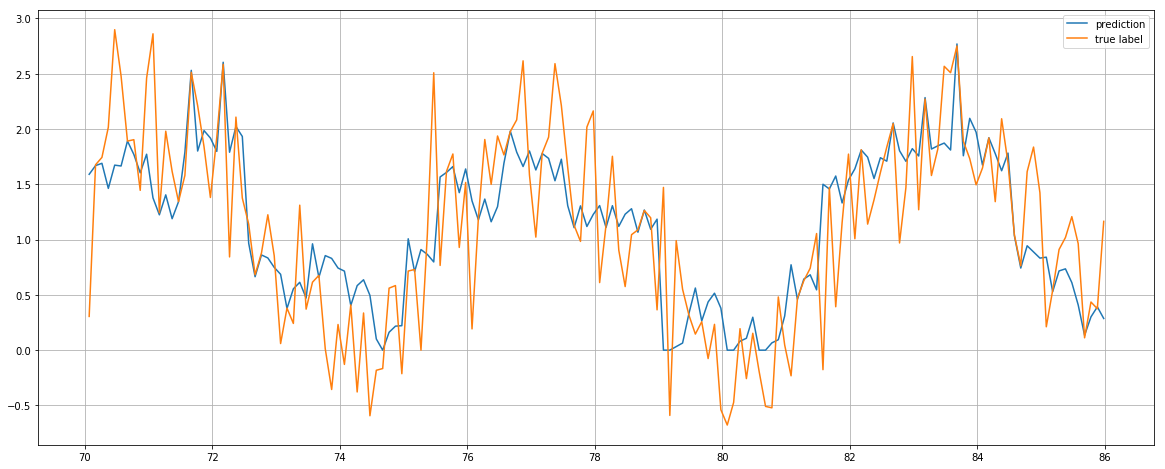

In [14]:
plt.figure(figsize=(20,8))
plt.plot(plot_ctest_x, test_pred, plot_ctest_x, np.roll(ctest_x.reshape(-1), 1))
plt.legend(['prediction', 'true label', 'smoothed'])
plt.grid(True)

#### Generate true prediction instead of relying on true input

In [15]:
test_x.shape

(60, 5, 1)

In [16]:
%%time
import copy

# define how many sequences we want to generate
# gen_len = 20
# assert gen_len < test_y.shape[0], 'sequence to be generated out of range'
# test_y1 = copy.deepcopy(test_y[:gen_len])

test_x_fake = np.zeros(test_x.shape)+1e1
# we only need the first element as input
# test_x_fake[0,0,0] = test_x[0,0,0]
fake_x, fake_y = get_minibatches(test_x_fake, np.roll(test_x,1), batch_size, shuffle=False)
_, true_x = get_minibatches(test_x_fake, test_x, batch_size, shuffle=False)

print('fake_x shape:', fake_x.shape)
fake_result = []
for i in range(fake_x.shape[0]):
    print(i)
    fake_x[i]
    fake_x[i][:, 0, 0] = true_x[i][:, 0, 0]
    for j in range(batch_size):
        for k in range(seq_len-1):
            pred_i = sess.run([pred], feed_dict={X: fake_x[i]})[0]
            fake_x[i][j][k+1] = pred_i[j][k]
    fake_result.append(pred_i)
gen_result = np.array(fake_result).reshape(-1)
print(gen_result.shape)

fake_x shape: (1, 32, 5, 1)
0
(160,)
CPU times: user 472 ms, sys: 56 ms, total: 528 ms
Wall time: 171 ms


In [17]:
i

0

In [18]:
plot_test_x.shape

(60, 5, 1)

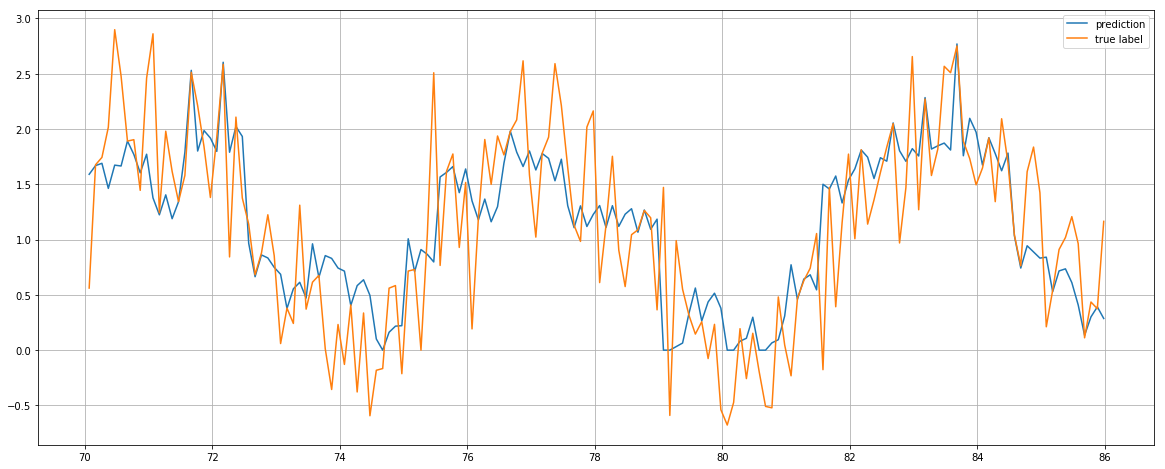

In [19]:
plt.figure(figsize=(20,8))
plot_test_x = plot_test_x[0:batch_size*fake_x.shape[0], :, :]
plot_test_x = plot_test_x.reshape(-1)
plt.plot(plot_test_x, gen_result, plot_test_x, fake_y.reshape(-1))
plt.legend(['prediction', 'true label', 'smoothed'])
plt.grid(True)

this matches with what we have in regular test stage, which means the model indeed doesn't rely on the next time step true input, however, notice this is not the true sequence generation as this only self generates for the length of sequence length